In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

Using TensorFlow backend.


In [2]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [3]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            #if i==0:
            #    print("random")
            #    np.random.shuffle(annotation_lines)
            print(annotation_lines[i])
            image, box = get_random_data(annotation_lines[i], input_shape, random=False)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = model.predict(image_data)
     

        yield image_data , box_data , y_true , m_true  #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model)

In [161]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

#yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
#yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
#yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


#model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )



In [330]:
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

batch_size = 1

image = {}
box = {}
train_logits = {}
model_logits = {}

datagen = data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model)

D:\FinalProject\ComputerVision\yolov3_keras/VOCdevkit/VOC2007/JPEGImages/000023.jpg 9,230,245,500,1 230,220,334,500,1 2,1,117,369,14 3,2,243,462,14 225,1,334,486,14



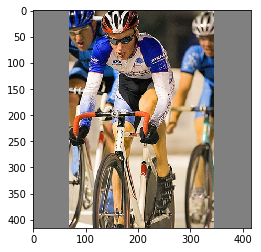

In [333]:
img,box_data,flogits,mlogits = next(datagen)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(img[0])
plt.show()

In [334]:
box_data.shape

(1, 20, 5)

In [237]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs



In [238]:
def box_iou(b1, b2):
    '''Return iou tensor

    Parameters
    ----------
    b1: tensor, shape=(i1,...,iN, 4), xywh
    b2: tensor, shape=(j, 4), xywh

    Returns
    -------
    iou: tensor, shape=(i1,...,iN, j)

    '''

    # Expand dim to apply broadcasting.
    b1 = K.expand_dims(b1, -2)
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh/2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half

    # Expand dim to apply broadcasting.
    b2 = K.expand_dims(b2, 0)
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half

    intersect_mins = K.maximum(b1_mins, b2_mins)
    intersect_maxes = K.minimum(b1_maxes, b2_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    iou = intersect_area / (b1_area + b2_area - intersect_area)

    return iou

In [239]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap  

In [240]:
mlogits[2].shape

(1, 52, 52, 75)

## loop this every scale

Prepare Prediction

In [335]:
l=0

In [336]:
import tensorflow as tf
#with tf.variable_scope("pred", reuse=True):
#outputm = tf.get_variable("tf_var_initialized_from_np", initializer= mlogits[l] )
outputm = tf.Variable(mlogits[l])

In [337]:
num_layers = len(anchors)//3 # default setting
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

pred_xy, pred_wh , pred_conf , pred_class = yolo_head( outputm ,anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=False)
pred_box = K.concatenate([pred_xy, pred_wh])
    

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(pred_box.eval().shape)
    print(pred_conf.eval().shape)
    print(pred_class.eval().shape)
    pred_box = pred_box.eval()
    pred_conf = pred_conf.eval()
    pred_class = pred_class.eval()

(1, 13, 13, 3, 4)
(1, 13, 13, 3, 1)
(1, 13, 13, 3, 20)


Prepare iou

In [338]:
object_mask = flogits[l][..., 4:5]
object_mask.shape

(1, 13, 13, 3, 1)

In [339]:
object_mask_bool = K.cast(object_mask, 'bool')
true_box = tf.boolean_mask(flogits[l][0,...,0:4], object_mask_bool[0,...,0])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print(object_mask_bool.eval().shape)
    print(true_box.eval())
#x y w h of true box    

(1, 13, 13, 3, 1)
[[0.28365386 0.36778846 0.23076923 0.7379808 ]
 [0.41105768 0.46153846 0.48076922 0.9206731 ]
 [0.7235577  0.48557693 0.21634616 0.97115386]
 [0.41826922 0.72836536 0.47115386 0.54086536]
 [0.72836536 0.71875    0.20673077 0.56009614]]


In [340]:
iou = box_iou(pred_box, true_box)
best_iou = K.max(iou, axis=-1)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print( iou.eval().shape )
    #iou = np.expand_dims( iou.eval() , axis=0)
    #print(iou.shape)
    #print( best_iou.eval().shape )
    #best_iou = np.expand_dims( best_iou.eval() , axis=0)
    print(best_iou.shape)
    best_iou = best_iou.eval()

(1, 13, 13, 3, 5)
(1, 13, 13, 3)


evaluate with label

In [358]:
arrpl = flogits[2]
boxl = np.where(arrpl[...,4] > 0 )
boxl = np.transpose(boxl)
boxl

array([], shape=(0, 4), dtype=int64)

In [342]:
iou_thres = 0.5
conf_thres = 0.5

false_positives = np.zeros((0,))
true_positives  = np.zeros((0,))
scores          = np.zeros((0,))

arrp= arrpl
box = boxl
for i in range(len(box)):
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print( "({})".format(box[i]) )
    print( arrp[tuple(box[i])][0:5] )
    print( arrp[tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( pred_box[ tuple(box[i]) ] )
    print( pred_conf[ tuple(box[i]) ] )
    print( pred_class[ tuple(box[i]) ] )
    pred_label =  np.argmax( pred_class[tuple(box[i])]) 
    print( "{} = {}".format(pred_label, obj[ pred_label] ) )
    print("-------------------------------------------------------")
    scores = np.append(scores, pred_conf[ tuple(box[i]) ] )
    if( best_iou[tuple(box[i])] > iou_thres and  pred_conf[tuple(box[i])] > conf_thres and (true_label and pred_label) ):
        #print( best_iou[tuple(box[i])] )
        false_positives = np.append(false_positives, 0)
        true_positives   = np.append(true_positives, 1)
    else:
        false_positives = np.append(false_positives, 1)
        true_positives  = np.append(true_positives, 0)
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
([0 4 3 1])
[0.28365386 0.36778846 0.23076923 0.7379808  1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
14 = person
-------------------------------------------------------
[0.25549942 0.34286302 0.17930362 0.63381857]
[0.00044747]
[3.85077401e-05 6.19066763e-04 2.60959816e-04 6.05881578e-05
 1.10845768e-03 8.97155187e-05 5.51283301e-04 3.40339640e-04
 1.34171767e-03 2.29787838e-04 7.15793285e-04 8.22944494e-05
 1.74507988e-03 3.89023975e-04 9.91172493e-01 7.73149822e-03
 2.10893704e-04 3.46715315e-05 1.17288175e-04 6.38848578e-05]
14 = person
-------------------------------------------------------
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
([0 6 5 2])
[0.41105768 0.46153846 0.48076922 0.9206731  1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
14 = person
-------------------------------------------------------
[0.41749817 

In [361]:
arrpl = flogits[1]
boxl = np.where(arrpl[...,4] > 0 )
boxl = np.transpose(boxl)
boxl

array([], shape=(0, 4), dtype=int64)

In [343]:
true_positives

array([0., 1., 1., 1., 1.])

In [344]:
false_positives

array([1., 0., 0., 0., 0.])

In [345]:
indices         = np.argsort(-scores)
false_positives = false_positives[indices]
true_positives  = true_positives[indices]

In [346]:
true_positives

array([1., 1., 1., 1., 0.])

In [347]:
false_positives = np.cumsum(false_positives)
true_positives  = np.cumsum(true_positives)

In [348]:
true_positives 

array([1., 2., 3., 4., 4.])

In [349]:
recall = true_positives  / len(box)
recall

array([0.2, 0.4, 0.6, 0.8, 0.8])

In [350]:
precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
precision

array([1. , 1. , 1. , 1. , 0.8])

In [352]:
np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

array([1., 2., 3., 4., 5.])

In [351]:
average_precision  = compute_ap(recall, precision)
average_precision

0.8

In [298]:
true_positives = np.array( [0,1,1] )
print( true_positives )
true_positives  = np.cumsum(true_positives)
print( true_positives )

false_positives = np.array( [1,0,0] )
print( false_positives )

false_positives = np.cumsum(false_positives)
print( false_positives )

recall = true_positives  / 3
print( recall )

precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
print( precision )

average_precision  = compute_ap(recall, precision)
print( average_precision )

[0 1 1]
[0 1 2]
[1 0 0]
[1 1 1]
[0.         0.33333333 0.66666667]
[0.         0.5        0.66666667]
0.4444444444444444


In [299]:
true_positives = np.array( [1,1,0] )
print( true_positives )
true_positives  = np.cumsum(true_positives)
print( true_positives )

false_positives = np.array( [0,0,1] )
print( false_positives )

false_positives = np.cumsum(false_positives)
print( false_positives )


recall = true_positives  / 3
print( recall )

precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
print( precision )

average_precision  = compute_ap(recall, precision)
print( average_precision )

[1 1 0]
[1 2 2]
[0 0 1]
[0 0 1]
[0.33333333 0.66666667 0.66666667]
[1.         1.         0.66666667]
0.6666666666666666


In [300]:
true_positives = np.array( [1,0,1] )
print( true_positives )
true_positives  = np.cumsum(true_positives)
print( true_positives )

false_positives = np.array( [0,1,0] )
print( false_positives )

false_positives = np.cumsum(false_positives)
print( false_positives )


recall = true_positives  / 3
print( recall )

precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
print( precision )

average_precision  = compute_ap(recall, precision)
print( average_precision )

[1 0 1]
[1 1 2]
[0 1 0]
[0 1 1]
[0.33333333 0.33333333 0.66666667]
[1.         0.5        0.66666667]
0.5555555555555556


In [288]:
mean_average_precision = []
mean_average_precision.append(0.6)
mean_average_precision.append(0.4)
np.mean(mean_average_precision)

0.5